### Numerical Experiments

6 openml datasets with ids [31, 1464, 334, 333, 1504]
all four optimizers are compared

In [1]:
import openml

from openml import tasks

import HPO

import pysgpp

import sys

import math
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import sklearn.metrics

from sklearn.model_selection import cross_val_score

import numpy as np
import keras

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, BatchNormalization
from scikeras.wrappers import KerasRegressor, KerasClassifier


def to_standard(lower, upper, value):
    return (value-lower)/(upper-lower)


def from_standard(lower, upper, value):
    return value*(upper-lower)+lower

BUDGET = 2
VERBOSE = 0
CV = 2
SCORING = 'neg_mean_squared_error'
TESTING = False

ITER = 5

DATASETS = []

GRID_RESULT = []
RANDOM_RESULT = []
BAYESIAN_RESULT = []
SPARSE_RESULT = []
SPARSE_RESULT_OPTIMIZED = []

GRID_COST = []
RANDOM_COST = []
BAYESIAN_COST = []
SPARSE_COST = []
SPARSE_COST_OPTIMIZED = []

2023-04-07 15:24:41.669715: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-07 15:24:43.543768: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/maxi/Repos/SGpp/lib:
2023-04-07 15:24:43.544049: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/maxi/Repos/SGpp/lib:
2023-04-07 15:24:43.544063: W tensorflow/compiler/tf2tensorrt/utils/py_utils

In [2]:
hyperparameterspace = {
    'loss': ["list", 'mean_absolute_error', 'mean_squared_error'],
    'epochs': ["interval-int", 1, 40],
    'batch_size': ["interval-int", 40, 160],
    'optimizer': ["list", 'SGD', 'RMSprop'],#, 'Adagrad', 'Adadelta', 'Adam', 'Adamax', 'Nadam'],
    'optimizer__learning_rate': ["interval", 0.0000001, 0.001]
}

In [3]:
ids = [233214, 233211, 359935, 359952, 359940]#, 359931, 317614, 359949, 359934, 359946, 359938, 359932, 359943]

for j in range(ITER):
    BUDGET = 10 + j * 10

    valid_datasets = 0
    for i in range(len(ids)):
        task = tasks.get_task(ids[i])
        
        # Get dataset by ID
        dataset = task.get_dataset()

        print("Current dataset:", i, "of", len(ids), "with name:", dataset.name)

        # Get the data itself as a dataframe (or otherwise)
        data, target, _, _ = dataset.get_data(dataset.default_target_attribute, dataset_format="array")
        if np.isnan(data).any() or np.isnan(target).any():
            print("NaN detected, skipping dataset")
            continue

        X = torch.Tensor(data[:100])
        Y = torch.Tensor(target[:100])

        # lengths = [len(x) for x in X]
        # for i in range(len(lengths)):
        #     if lengths[i] != lengths[0]:
        #         print("Not same length")

        dataset = HPO.Dataset(X, Y)

        ################## MODEL AND FUNCTION DEFINITION ####################

        # Function to create model, required for KerasClassifier
        def create_model(): 
            # create model
            model = Sequential()
            model.add(Dense(20, input_shape=(len(dataset.get_X()[0]),), activation='softsign'))
            model.add(BatchNormalization())
            model.add(Dense(20, activation='softsign'))
            model.add(BatchNormalization())
            model.add(Dense(1, activation='softsign'))
            return model

        hyperparameterspace_special = {}
        for key in hyperparameterspace.keys():
            liste = []
            for i in range(1, len(hyperparameterspace[key])):
                liste.append(hyperparameterspace[key][i])
            hyperparameterspace_special[key] = liste

        def blackboxfunction(params):
            index = int(params[0]*(len(hyperparameterspace_special["loss"])-1))
            loss = hyperparameterspace_special["loss"][index]
            
            epochs = int(params[1])

            batch_size = int(params[2])

            index = int(params[3]*(len(hyperparameterspace_special["optimizer"])-1))
            model_optimizer = hyperparameterspace_special["optimizer"][index]

            model_learning_rate = params[4]

            # Function to create model, required for KerasClassifier
            def create_model():
                # create model
                model = Sequential()
                model.add(Dense(20, input_shape=(len(dataset.get_X()[0]),), activation='softsign'))
                model.add(BatchNormalization())
                model.add(Dense(20, activation='softsign'))
                model.add(BatchNormalization())
                model.add(Dense(1, activation='softsign'))
                # Compile model
                if model_optimizer == 'SGD':
                    optimizer = keras.optimizers.SGD(learning_rate=model_learning_rate)
                elif model_optimizer == 'RMSprop':
                    optimizer = keras.optimizers.RMSprop(learning_rate=model_learning_rate)
                elif model_optimizer =='Adagrad':
                    optimizer = keras.optimizers.Adagrad(learning_rate=model_learning_rate)
                elif model_optimizer =='Adadelta':
                    optimizer = keras.optimizers.Adadelta(learning_rate=model_learning_rate)
                elif model_optimizer =='Adam':
                    optimizer = keras.optimizers.Adam(learning_rate=model_learning_rate)
                elif model_optimizer =='Adamax':
                    optimizer = keras.optimizers.Adamax(learning_rate=model_learning_rate)
                elif model_optimizer == 'Nadam':
                    optimizer = keras.optimizers.Nadam(learning_rate=model_learning_rate)


                model.compile(loss=loss, optimizer=optimizer)
                return model

            model = KerasRegressor(model=create_model, verbose=0)

            model.fit(dataset.get_X_train(), dataset.get_Y_train(), epochs=epochs, batch_size=batch_size)

            if TESTING:
                print("Test set is being used")
                Y_predicted = model.predict(dataset.get_X_test())
                if np.any(np.isnan(Y_predicted)):
                    return 1000
                return -sklearn.metrics.mean_squared_error(dataset.get_Y_test(), Y_predicted)
            else:
                Y_predicted = model.predict(dataset.get_X_validation())
                if np.any(np.isnan(Y_predicted)):
                    return 1000
                return -sklearn.metrics.mean_squared_error(dataset.get_Y_validation(), Y_predicted)
        

        ##################### Function for sparse grid search #####################

        class ExampleFunction(pysgpp.ScalarFunction):

            def __init__(self):
                super(ExampleFunction, self).__init__(len(hyperparameterspace.keys()))


            def eval(self, x):
                index = int(x[0]*(len(hyperparameterspace_special["loss"])-1))
                loss = hyperparameterspace_special["loss"][index]
                
                epochs = int(from_standard(hyperparameterspace_special["epochs"][0], hyperparameterspace_special["epochs"][1], x[1]))

                batch_size = int(from_standard(hyperparameterspace_special["batch_size"][0], hyperparameterspace_special["batch_size"][1], x[2]))

                index = int(x[3]*(len(hyperparameterspace_special["optimizer"])-1))
                model_optimizer = hyperparameterspace_special["optimizer"][index]

                model_learning_rate = from_standard(hyperparameterspace_special["optimizer__learning_rate"][0], hyperparameterspace_special["optimizer__learning_rate"][1], x[4])
                
                # Function to create model, required for KerasClassifier
                def create_model():
                    # create model
                    model = Sequential()
                    model.add(Dense(20, input_shape=(len(dataset.get_X()[0]),), activation='softsign'))
                    model.add(BatchNormalization())
                    model.add(Dense(20, activation='softsign'))
                    model.add(BatchNormalization())
                    model.add(Dense(1, activation='softsign'))
                    # Compile model
                    if model_optimizer == 'SGD':
                        optimizer = keras.optimizers.SGD(learning_rate=model_learning_rate)
                    elif model_optimizer == 'RMSprop':
                        optimizer = keras.optimizers.RMSprop(learning_rate=model_learning_rate)
                    elif model_optimizer =='Adagrad':
                        optimizer = keras.optimizers.Adagrad(learning_rate=model_learning_rate)
                    elif model_optimizer =='Adadelta':
                        optimizer = keras.optimizers.Adadelta(learning_rate=model_learning_rate)
                    elif model_optimizer =='Adam':
                        optimizer = keras.optimizers.Adam(learning_rate=model_learning_rate)
                    elif model_optimizer =='Adamax':
                        optimizer = keras.optimizers.Adamax(learning_rate=model_learning_rate)
                    elif model_optimizer == 'Nadam':
                        optimizer = keras.optimizers.Nadam(learning_rate=model_learning_rate)

                    model.compile(loss=loss, optimizer=optimizer,)
                    return model

                model = KerasRegressor(model=create_model, verbose=0)

                model.fit(dataset.get_X_train(), dataset.get_Y_train(), epochs=epochs, batch_size=batch_size)

                if TESTING:
                    Y_predicted = model.predict(dataset.get_X_test())
                    if np.any(np.isnan(Y_predicted)):
                        return 1000
                    return sklearn.metrics.mean_squared_error(dataset.get_Y_test().tolist(), Y_predicted)
                else:
                    Y_predicted = model.predict(dataset.get_X_validation())
                    if np.any(np.isnan(Y_predicted)):
                        return 1000
                    return sklearn.metrics.mean_squared_error(dataset.get_Y_validation().tolist(), Y_predicted)
                

        # ############################# GRID SEARCH #######################
        print("Performing grid search")
        
        model = KerasRegressor(model=create_model, verbose=0)

        optimization = HPO.GridSearchOptimization(dataset, model, hyperparameterspace, budget=BUDGET, verbosity=VERBOSE, cv=CV)

        result, cost = optimization.fit()

        Y_predicted = result.predict(dataset.get_X_test())

        GRID_RESULT.append(sklearn.metrics.mean_squared_error(dataset.get_Y_test(), Y_predicted))
        GRID_COST.append(cost)

        ########################### RANDOM SEARCH #######################
        print("Performing random search")
        
        model = KerasRegressor(model=create_model, verbose=0)

        optimization = HPO.RandomSearchOptimization(dataset, model, hyperparameterspace, budget=BUDGET, verbosity=VERBOSE, cv=CV)

        result, cost = optimization.fit()

        Y_predicted = result.predict(dataset.get_X_test())

        RANDOM_RESULT.append(sklearn.metrics.mean_squared_error(dataset.get_Y_test(), Y_predicted))
        RANDOM_COST.append(cost)

        ########################### BAYESIAN OPT ##################### 
        print("Performing bayesian optimization")

        optimization = HPO.BayesianOptimization(dataset, blackboxfunction, hyperparameterspace, budget=BUDGET, verbosity=VERBOSE)


        result = optimization.fit()
        
        index_best = 0
        for i in range(len(result[1])):
            if result[1][i] == max(result[1]):
                index_best = i

        best_score = result[1][index_best]
        best_params = result[0][index_best]

        TESTING = True
        BAYESIAN_RESULT.append(-blackboxfunction(best_params))
        TESTING = False

        BAYESIAN_COST.append(BUDGET)


        ########################### SPARSE OPT ############################
        print("Performing sparse search")

        f = ExampleFunction()

        optimization = HPO.SparseGridSearchOptimization(dataset, f, hyperparameterspace, budget=BUDGET, verbosity=VERBOSE, degree=2, adaptivity=0.9, optimizer="gradient_descent")

        result = optimization.fit()
        

        TESTING = True
        SPARSE_RESULT.append(f.eval(result[0]))
        SPARSE_RESULT_OPTIMIZED.append(f.eval(result[1]))
        TESTING = False

        SPARSE_COST.append(BUDGET)
        SPARSE_COST_OPTIMIZED.append(BUDGET)

        valid_datasets += 1
    



Current dataset: 0 of 5 with name: Santander_transaction_value
Performing grid search


2023-04-07 15:24:52.260825: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:267] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2023-04-07 15:24:52.260941: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (maxi-XPS-15-9560): /proc/driver/nvidia/version does not exist
2023-04-07 15:24:52.263664: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Performing random search


/home/maxi/.local/lib/python3.10/site-packages/sklearn/model_selection/_search.py:305: UserWarning: The total space of parameters 4 is smaller than n_iter=10. Running 4 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Performing bayesian optimization


/home/maxi/.local/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/maxi/.local/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Iterations took 28.680304666995653 seconds
Test set is being used
Performing sparse search
Adaptive grid generation (Ritter-Novak)...
Done in 61241ms.
Solving linear system (automatic method)...
Done in 1ms.
Optimizing (gradient descent)...
Done in 0ms.
Current dataset: 1 of 5 with name: diamonds
Performing grid search
Performing random search


/home/maxi/.local/lib/python3.10/site-packages/sklearn/model_selection/_search.py:305: UserWarning: The total space of parameters 4 is smaller than n_iter=10. Running 4 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Performing bayesian optimization


/home/maxi/.local/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/maxi/.local/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/maxi/.local/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/maxi/.local/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: 

Iterations took 12.592942704985035 seconds
Test set is being used
Performing sparse search
Adaptive grid generation (Ritter-Novak)...
Done in 60472ms.
Solving linear system (automatic method)...
Done in 0ms.
Optimizing (gradient descent)...
Done in 0ms.
Current dataset: 2 of 5 with name: wine_quality
Performing grid search
Performing random search


/home/maxi/.local/lib/python3.10/site-packages/sklearn/model_selection/_search.py:305: UserWarning: The total space of parameters 4 is smaller than n_iter=10. Running 4 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Performing bayesian optimization
Iterations took 18.20468407300359 seconds
Test set is being used
Performing sparse search
Adaptive grid generation (Ritter-Novak)...
Done in 60794ms.
Solving linear system (automatic method)...
Done in 0ms.
Optimizing (gradient descent)...
Done in 0ms.
Current dataset: 3 of 5 with name: house_16H
Performing grid search
Performing random search


/home/maxi/.local/lib/python3.10/site-packages/sklearn/model_selection/_search.py:305: UserWarning: The total space of parameters 4 is smaller than n_iter=10. Running 4 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Performing bayesian optimization
Iterations took 62.84783793501265 seconds
Test set is being used
Performing sparse search
Adaptive grid generation (Ritter-Novak)...
Done in 61806ms.
Solving linear system (automatic method)...
Done in 0ms.
Optimizing (gradient descent)...
Done in 0ms.
Current dataset: 4 of 5 with name: yprop_4_1
Performing grid search
Performing random search


/home/maxi/.local/lib/python3.10/site-packages/sklearn/model_selection/_search.py:305: UserWarning: The total space of parameters 4 is smaller than n_iter=10. Running 4 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Performing bayesian optimization


/home/maxi/.local/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Iterations took 39.67244936700445 seconds
Test set is being used
Performing sparse search
Adaptive grid generation (Ritter-Novak)...
Done in 62714ms.
Solving linear system (automatic method)...
Done in 0ms.
Optimizing (gradient descent)...
Done in 0ms.
Current dataset: 0 of 5 with name: Santander_transaction_value
Performing grid search
Performing random search


/home/maxi/.local/lib/python3.10/site-packages/sklearn/model_selection/_search.py:305: UserWarning: The total space of parameters 4 is smaller than n_iter=10. Running 4 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Performing bayesian optimization
Iterations took 75.42293692199746 seconds
Test set is being used
Performing sparse search
Adaptive grid generation (Ritter-Novak)...
Done in 64858ms.
Solving linear system (automatic method)...
Done in 0ms.
Optimizing (gradient descent)...
Done in 0ms.
Current dataset: 1 of 5 with name: diamonds
Performing grid search
Performing random search


/home/maxi/.local/lib/python3.10/site-packages/sklearn/model_selection/_search.py:305: UserWarning: The total space of parameters 4 is smaller than n_iter=10. Running 4 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Performing bayesian optimization


/home/maxi/.local/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/maxi/.local/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/maxi/.local/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/maxi/.local/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: 

Iterations took 33.682560840054066 seconds
Test set is being used
Performing sparse search
Adaptive grid generation (Ritter-Novak)...
Done in 64347ms.
Solving linear system (automatic method)...
Done in 0ms.
Optimizing (gradient descent)...
Done in 0ms.
Current dataset: 2 of 5 with name: wine_quality
Performing grid search
Performing random search


/home/maxi/.local/lib/python3.10/site-packages/sklearn/model_selection/_search.py:305: UserWarning: The total space of parameters 4 is smaller than n_iter=10. Running 4 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Performing bayesian optimization


/home/maxi/.local/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/maxi/.local/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/maxi/.local/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/maxi/.local/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: 

Iterations took 30.28428915499535 seconds
Test set is being used
Performing sparse search
Adaptive grid generation (Ritter-Novak)...
Done in 63310ms.
Solving linear system (automatic method)...
Done in 0ms.
Optimizing (gradient descent)...
Done in 0ms.
Current dataset: 3 of 5 with name: house_16H
Performing grid search
Performing random search


/home/maxi/.local/lib/python3.10/site-packages/sklearn/model_selection/_search.py:305: UserWarning: The total space of parameters 4 is smaller than n_iter=10. Running 4 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Performing bayesian optimization
Iterations took 142.03353898902424 seconds
Test set is being used
Performing sparse search
Adaptive grid generation (Ritter-Novak)...
Done in 63529ms.
Solving linear system (automatic method)...
Done in 0ms.
Optimizing (gradient descent)...
Done in 0ms.
Current dataset: 4 of 5 with name: yprop_4_1
Performing grid search
Performing random search


/home/maxi/.local/lib/python3.10/site-packages/sklearn/model_selection/_search.py:305: UserWarning: The total space of parameters 4 is smaller than n_iter=10. Running 4 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Performing bayesian optimization


/home/maxi/.local/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/maxi/.local/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/maxi/.local/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/maxi/.local/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: 

Iterations took 27.271972081973217 seconds
Test set is being used
Performing sparse search
Adaptive grid generation (Ritter-Novak)...
Done in 62869ms.
Solving linear system (automatic method)...
Done in 0ms.
Optimizing (gradient descent)...
Done in 0ms.
Current dataset: 0 of 5 with name: Santander_transaction_value
Performing grid search
Performing random search


/home/maxi/.local/lib/python3.10/site-packages/sklearn/model_selection/_search.py:305: UserWarning: The total space of parameters 4 is smaller than n_iter=10. Running 4 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Performing bayesian optimization


/home/maxi/.local/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/maxi/.local/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/maxi/.local/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/maxi/.local/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: 

Iterations took 133.935270233982 seconds
Test set is being used
Performing sparse search
Adaptive grid generation (Ritter-Novak)...
Done in 64361ms.
Solving linear system (automatic method)...
Done in 0ms.
Optimizing (gradient descent)...
Done in 0ms.
Current dataset: 1 of 5 with name: diamonds
Performing grid search
Performing random search


/home/maxi/.local/lib/python3.10/site-packages/sklearn/model_selection/_search.py:305: UserWarning: The total space of parameters 4 is smaller than n_iter=10. Running 4 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Performing bayesian optimization


/home/maxi/.local/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/maxi/.local/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/maxi/.local/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/maxi/.local/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: 

Iterations took 72.92655748603283 seconds
Test set is being used
Performing sparse search
Adaptive grid generation (Ritter-Novak)...
Done in 64394ms.
Solving linear system (automatic method)...
Done in 0ms.
Optimizing (gradient descent)...
Done in 0ms.
Current dataset: 2 of 5 with name: wine_quality
Performing grid search
Performing random search


/home/maxi/.local/lib/python3.10/site-packages/sklearn/model_selection/_search.py:305: UserWarning: The total space of parameters 4 is smaller than n_iter=10. Running 4 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Performing bayesian optimization


/home/maxi/.local/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/maxi/.local/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/maxi/.local/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/maxi/.local/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: 

Iterations took 40.963920910071465 seconds
Test set is being used
Performing sparse search
Adaptive grid generation (Ritter-Novak)...
Done in 63422ms.
Solving linear system (automatic method)...
Done in 0ms.
Optimizing (gradient descent)...
Done in 0ms.
Current dataset: 3 of 5 with name: house_16H
Performing grid search
Performing random search


/home/maxi/.local/lib/python3.10/site-packages/sklearn/model_selection/_search.py:305: UserWarning: The total space of parameters 4 is smaller than n_iter=10. Running 4 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Performing bayesian optimization
Iterations took 150.8596067599865 seconds
Test set is being used
Performing sparse search
Adaptive grid generation (Ritter-Novak)...
Done in 64956ms.
Solving linear system (automatic method)...
Done in 0ms.
Optimizing (gradient descent)...
Done in 0ms.
Current dataset: 4 of 5 with name: yprop_4_1
Performing grid search
Performing random search


/home/maxi/.local/lib/python3.10/site-packages/sklearn/model_selection/_search.py:305: UserWarning: The total space of parameters 4 is smaller than n_iter=10. Running 4 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Performing bayesian optimization


/home/maxi/.local/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/maxi/.local/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/maxi/.local/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/maxi/.local/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: 

Iterations took 42.8162631989253 seconds
Test set is being used
Performing sparse search
Adaptive grid generation (Ritter-Novak)...
Done in 63595ms.
Solving linear system (automatic method)...
Done in 0ms.
Optimizing (gradient descent)...
Done in 0ms.
Current dataset: 0 of 5 with name: Santander_transaction_value
Performing grid search
Performing random search
Performing bayesian optimization


/home/maxi/.local/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/maxi/.local/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/maxi/.local/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/maxi/.local/lib/python3.10/site-packages/sklearn/gaussian_process/kernels

Iterations took 99.8130460769462 seconds
Test set is being used
Performing sparse search
Adaptive grid generation (Ritter-Novak)...
Done in 65208ms.
Solving linear system (automatic method)...
Done in 0ms.
Optimizing (gradient descent)...
Done in 0ms.
Current dataset: 1 of 5 with name: diamonds
Performing grid search
Performing random search
Performing bayesian optimization


/home/maxi/.local/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/maxi/.local/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/maxi/.local/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/maxi/.local/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: 

Iterations took 54.94674804502574 seconds
Test set is being used
Performing sparse search
Adaptive grid generation (Ritter-Novak)...
Done in 64044ms.
Solving linear system (automatic method)...
Done in 0ms.
Optimizing (gradient descent)...
Done in 0ms.
Current dataset: 2 of 5 with name: wine_quality
Performing grid search
Performing random search
Performing bayesian optimization


/home/maxi/.local/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/maxi/.local/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/maxi/.local/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/maxi/.local/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: 

Iterations took 49.770585234000464 seconds
Test set is being used
Performing sparse search
Adaptive grid generation (Ritter-Novak)...
Done in 63730ms.
Solving linear system (automatic method)...
Done in 0ms.
Optimizing (gradient descent)...
Done in 1ms.
Current dataset: 3 of 5 with name: house_16H
Performing grid search
Performing random search
Performing bayesian optimization


/home/maxi/.local/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/maxi/.local/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/maxi/.local/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/maxi/.local/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: 

Iterations took 70.9533862429671 seconds
Test set is being used
Performing sparse search
Adaptive grid generation (Ritter-Novak)...
Done in 64648ms.
Solving linear system (automatic method)...
Done in 0ms.
Optimizing (gradient descent)...
Done in 0ms.
Current dataset: 4 of 5 with name: yprop_4_1
Performing grid search
Performing random search
Performing bayesian optimization


/home/maxi/.local/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/maxi/.local/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/maxi/.local/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Iterations took 55.73157832599827 seconds
Test set is being used
Performing sparse search
Adaptive grid generation (Ritter-Novak)...
Done in 65248ms.
Solving linear system (automatic method)...
Done in 0ms.
Optimizing (gradient descent)...
Done in 0ms.
Current dataset: 0 of 5 with name: Santander_transaction_value
Performing grid search
Performing random search
Performing bayesian optimization


/home/maxi/.local/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


Iterations took 242.43077090306906 seconds
Test set is being used
Performing sparse search
Adaptive grid generation (Ritter-Novak)...
Done in 66807ms.
Solving linear system (automatic method)...
Done in 0ms.
Optimizing (gradient descent)...
Done in 0ms.
Current dataset: 1 of 5 with name: diamonds
Performing grid search
Performing random search
Performing bayesian optimization


/home/maxi/.local/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/maxi/.local/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/maxi/.local/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/maxi/.local/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: 

Iterations took 64.47670269297669 seconds
Test set is being used
Performing sparse search
Adaptive grid generation (Ritter-Novak)...
Done in 64338ms.
Solving linear system (automatic method)...
Done in 0ms.
Optimizing (gradient descent)...
Done in 0ms.
Current dataset: 2 of 5 with name: wine_quality
Performing grid search
Performing random search
Performing bayesian optimization


/home/maxi/.local/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/maxi/.local/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/maxi/.local/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/maxi/.local/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: 

Iterations took 136.1693385699764 seconds
Test set is being used
Performing sparse search
Adaptive grid generation (Ritter-Novak)...
Done in 63417ms.
Solving linear system (automatic method)...
Done in 0ms.
Optimizing (gradient descent)...
Done in 2ms.
Current dataset: 3 of 5 with name: house_16H
Performing grid search
Performing random search
Performing bayesian optimization


/home/maxi/.local/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/maxi/.local/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/maxi/.local/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/maxi/.local/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: 

Iterations took 161.4147557909164 seconds
Test set is being used
Performing sparse search
Adaptive grid generation (Ritter-Novak)...
Done in 65010ms.
Solving linear system (automatic method)...
Done in 0ms.
Optimizing (gradient descent)...
Done in 0ms.
Current dataset: 4 of 5 with name: yprop_4_1
Performing grid search
Performing random search
Performing bayesian optimization


/home/maxi/.local/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/maxi/.local/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/maxi/.local/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/maxi/.local/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: 

Iterations took 63.7190769509034 seconds
Test set is being used
Performing sparse search
Adaptive grid generation (Ritter-Novak)...
Done in 66046ms.
Solving linear system (automatic method)...
Done in 0ms.
Optimizing (gradient descent)...
Done in 0ms.


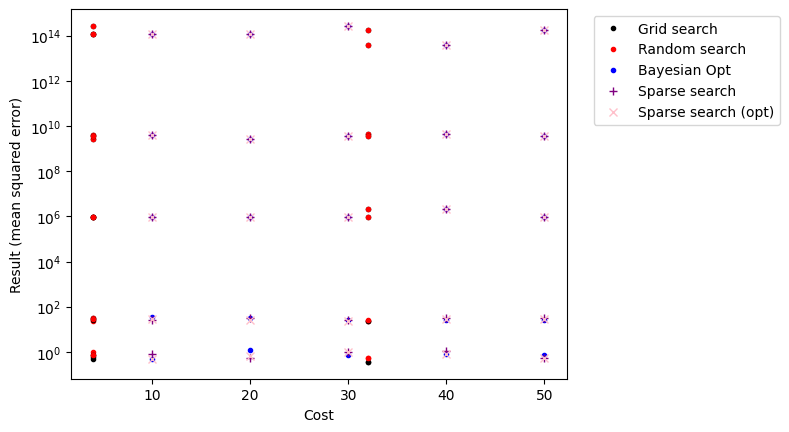

In [6]:
count = 0
for j in range(ITER):
    for i in range(valid_datasets):
        plt.plot(GRID_COST[count], GRID_RESULT[count], '.', color='black')
        plt.plot(RANDOM_COST[count], RANDOM_RESULT[count], '.', color='red')
        plt.plot(BAYESIAN_COST[count], BAYESIAN_RESULT[count], '.', color='blue')
        plt.plot(SPARSE_COST[count], SPARSE_RESULT[count], '+', color='purple')
        plt.plot(SPARSE_COST_OPTIMIZED[count], SPARSE_RESULT_OPTIMIZED[count], 'x', color='pink')

        count += 1

plt.xlabel("Cost")
plt.ylabel("Result (mean squared error)")
plt.yscale("log")
plt.legend(["Grid search", "Random search", "Bayesian Opt", "Sparse search", "Sparse search (opt)"], bbox_to_anchor=(1.04, 1), loc="upper left")
